## Problem Set #3
### MACS 30100, Dr. Evans

### Name: Xiang Zhang
### snzhang@uchicago.edu

### Problem One: Some income data, lognormal distribution, and GMM

I first import the packages to be used and the data

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

wages = np.loadtxt('incomes.txt')

#### (a) Histogram

Below I plot a histogram with 30 bins to show the income distribution

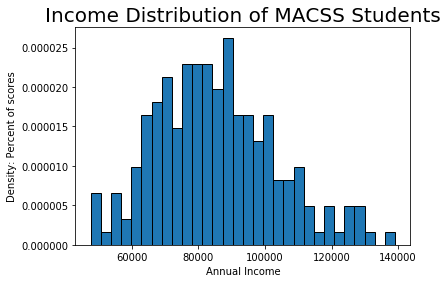

In [2]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title('Income Distribution of MACSS Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Density: Percent of scores')
plt.show()

#### (b) GMM Estimates

I first define the function computing log normal distribution

In [3]:
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and
    standard deviation sigma. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the log normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:

    pdf_vals = (N,) vector, log normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
            
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi) ) *
                   np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

Then I define the function computing the data moments

In [4]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    sd_data = np.sqrt(xvals.var())
  
    return mean_data, sd_data

Then I define the function generating model moments

In [5]:
def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    var_model = np.exp(2 * mu + sigma ** 2) * (np.exp(sigma ** 2) - 1)
    
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

Then the function defining moment error

In [6]:
def err_vec(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])

    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

And fianlly, the criterion function

In [7]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Now I start to implement GMM estimation

In [8]:
mu_init, sigma_init = data_moments(np.log(wages))
params_init = np.array([mu_init, sigma_init])

W_hat = np.eye(2)
gmm_args = (wages, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM_ident_mat, sig_GMM_ident_mat = results.x
print(results)

      fun: array([[  2.07488379e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921689e-05,   2.54907972e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])


I plot the estimated distribution against the histogram below

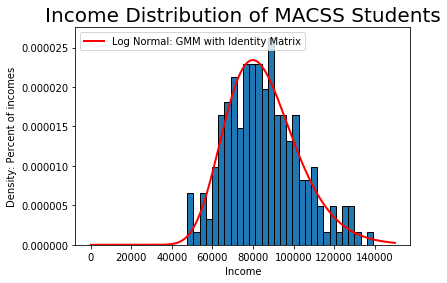

In [9]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='Log Normal: GMM with Identity Matrix')
plt.legend(loc='upper left')

plt.show()

In [10]:
print("GMM criterion function at the estimated parameter values is", results.fun[0])
print("Two data moments are", data_moments(wages))
print("Two model moments are", model_moments(mu_GMM_ident_mat, sig_GMM_ident_mat))
print("Error vector \n", err_vec(wages, mu_GMM_ident_mat, sig_GMM_ident_mat))

GMM criterion function at the estimated parameter values is [  2.07488379e-11]
Two data moments are (85276.823606258113, 17992.542128046523)
Two model moments are (85277.158375889354, 17992.583697689046)
Error vector 
 [[  3.92568129e-06]
 [  2.31038184e-06]]


#### (c) Two-step GMM
The code below performs a two-step GMM estimation

In [11]:
err_firststep = err_vec(wages, mu_GMM_ident_mat, sig_GMM_ident_mat)
VCV_2step = np.dot(err_firststep, err_firststep.T) / len(wages)
print("Variance-covariance matrix is \n", VCV_2step)

'''
# If sometimes found the elements in matrix is too small, use code below
for x in np.nditer(VCV_2step, op_flags=['readwrite']):
    if x < 1e-7:
        x[...] = 1e-7
'''

W_hat_2step = lin.pinv(VCV_2step)  
print("W_hat is \n", W_hat_2step)

Variance-covariance matrix is 
 [[  7.70548681e-14   4.53491138e-14]
 [  4.53491138e-14   2.66893211e-14]]
W_hat is 
 [[  7.15933228e+12   4.21348296e+12]
 [  4.21348296e+12   2.47976180e+12]]


In [12]:
mu_init, sigma_init = data_moments(np.log(wages))
params_init = np.array([mu_init, sigma_init])

W_hat = W_hat_2step
gmm_args = (wages, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM_2step, sig_GMM_2step = results.x
print(results)

      fun: array([[ 0.00045164]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.77424702e-01,   3.71019676e+05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 201
      nit: 6
   status: 2
  success: False
        x: array([ 11.32586446,   0.21167458])


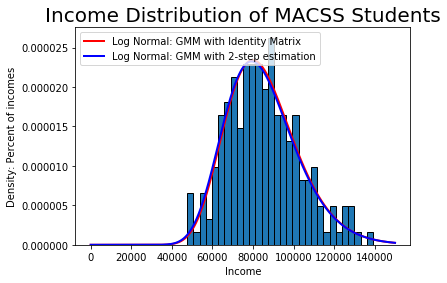

In [13]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='Log Normal: GMM with Identity Matrix')
plt.legend(loc='upper left')

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_2step, sig_GMM_2step),
         linewidth=2, color='b', label='Log Normal: GMM with 2-step estimation')
plt.legend(loc='upper left')

plt.show()

In [14]:
print("GMM criterion function at the estimated parameter values is", results.fun[0])
print("Two data moments are", data_moments(wages))
print("Two model moments are", model_moments(results.x[0], results.x[1]))
print("Error vector \n", err_vec(wages, results.x[0], results.x[1]))

GMM criterion function at the estimated parameter values is [ 0.00045164]
Two data moments are (85276.823606258113, 17992.542128046523)
Two model moments are (84818.378453149897, 18156.895846265455)
Error vector 
 [[-0.00537596]
 [ 0.00913455]]


#### (d) Change to different moments
Below I first define the data moment function

In [15]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 < x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x <= 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 x > 100000

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals <= 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals > 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

Then I define the function for model moments

In [16]:
def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-6, 75000 - 1e-6)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = (1, 0) - intgr.quad(xfx, 1e-6, 100000)* np.array([1, -1])
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

Then the Error vector

In [17]:
def err_vec3(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    
    err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

Then the criterion function

In [18]:
def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [19]:
mu_init, sigma_init = data_moments(np.log(wages))
params_init = np.array([mu_init, sigma_init])

W_hat = np.eye(3)
gmm_args = (wages, W_hat)

results = opt.minimize(criterion3, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_ident_mat, sig_GMM_ident_mat = results.x
print(results)

      fun: array([[  2.53446197e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.50342190e-06,  -3.56173135e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([ 11.33568133,   0.21059845])


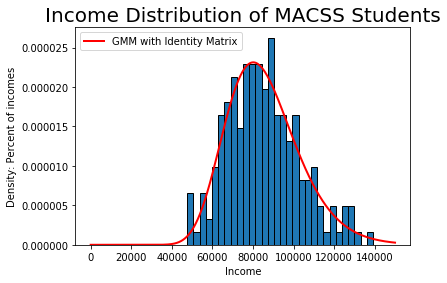

In [20]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, results.x[0], results.x[1]),
         linewidth=2, color='r', label='GMM with Identity Matrix')
plt.legend(loc='upper left')

plt.show()

In [21]:
print("GMM criterion function at the estimated parameter values is", results.fun[0])
print("Two data moments are", data_moments3(wages))
print("Two model moments are", model_moments3(results.x[0], results.x[1]))
print("Error vector \n", err_vec(wages, results.x[0], results.x[1]))

GMM criterion function at the estimated parameter values is [  2.53446197e-11]
Two data moments are (0.3, 0.5, 0.2)
Two model moments are (0.30000000362083074, 0.5000000058481757, 0.19999999050898098)
Error vector 
 [[ 0.00420802]
 [ 0.01356259]]


#### (d) Two-step GMM
Below I perform two-step GMM

In [22]:
err_firststep = err_vec(wages, results.x[0], results.x[1])
VCV_2step = np.dot(err_firststep, err_firststep.T) / len(wages)
print("Variance-covariance matrix is \n", VCV_2step)
'''
for x in np.nditer(VCV_2step, op_flags=['readwrite']):
    if x < 1e-7:
        x[...] = 1e-7
'''
W_hat_2step = lin.pinv(VCV_2step)  
print("W_hat is \n", W_hat_2step)

Variance-covariance matrix is 
 [[  8.85371054e-08   2.85358188e-07]
 [  2.85358188e-07   9.19719422e-07]]
W_hat is 
 [[  87092.99681788  280703.77546746]
 [ 280703.77546746  904718.08802785]]


In [23]:
mu_init, sigma_init = data_moments(np.log(wages))
params_init = np.array([mu_init, sigma_init])

W_hat = W_hat_2step
gmm_args = (wages, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM_2step, sig_GMM_2step = results.x
print('mu_GMM1=',mu_GMM_2step, ' sig_GMM1=', sig_GMM_2step)
print(results)

mu_GMM1= 11.3201824015  sig_GMM1= 0.211674510077
      fun: array([[  3.93937743e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.12698683e-04,   1.76412898e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 5
   status: 0
  success: True
        x: array([ 11.3201824 ,   0.21167451])


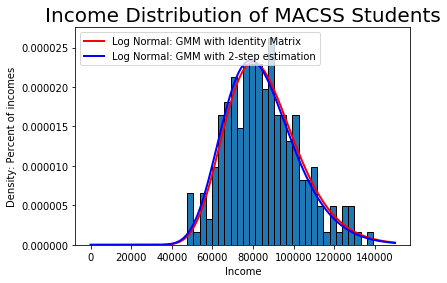

In [24]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='Log Normal: GMM with Identity Matrix')
plt.legend(loc='upper left')

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_2step, sig_GMM_2step),
         linewidth=2, color='b', label='Log Normal: GMM with 2-step estimation')
plt.legend(loc='upper left')

plt.show()

In [25]:
print("GMM criterion function at the estimated parameter values is", results.fun[0])
print("Two data moments are", data_moments3(wages))
print("Two model moments are", model_moments3(results.x[0], results.x[1]))
print("Error vector \n", err_vec(wages, results.x[0], results.x[1]))

GMM criterion function at the estimated parameter values is [  3.93937743e-11]
Two data moments are (0.3, 0.5, 0.2)
Two model moments are (0.3268910950046711, 0.49184617620552695, 0.18126272876707761)
Error vector 
 [[-0.01101147]
 [ 0.00341648]]


#### (e) Best Estimates
Basically, all these estimated are very close to each other. Having a closer look, answers from (b) and (c) are very close since they all use sample mean and standard deviation as the moments; similarly, answers from (d) and (e) are quite close since they all use the proportion as moments.

Theoretically, all these estimations are asymptotic equivalent and they are valid estimators. However, if I have to make a choice, I would choose the estimation from (d) and (e) since tey have smaller criterion function value, which suggests we get better estimation by using proportion as moments. And by theoretical design, using 2-step estimation should get better results. 

### Problem 2.Linear regression and GMM (3 points)

I first import pandas package and data

In [26]:
import pandas as pd
sick = pd.read_csv("sick.txt")

In [27]:
def data_moment(xvals):
    return xvals["sick"]

def model_moment(xvals, beta_0, beta_1, beta_2, beta_3):
    return beta_0 + beta_1 * xvals["age"] + beta_2 * xvals["children"] + beta_3 * xvals["avgtemp_winter"]

def err_vec(xvals, beta_0, beta_1, beta_2, beta_3):
    '''
    Compute Error Vector
    '''
    data_mom = data_moment(xvals)
    moms_data = np.array(data_mom)
    
    model_mom = model_moment(xvals, beta_0, beta_1, beta_2, beta_3)
    moms_model = np.array(model_mom)
    
    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    beta_0, beta_1, beta_2, beta_3 = params     
    xvals, W = args
    
    err = err_vec(xvals, beta_0, beta_1, beta_2, beta_3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [28]:
params_init = np.array([1, 2, 3, 4])

W_hat = np.eye(200)
gmm_args = (sick, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', \
                       bounds=((None, None), (None, None), (None, None), (None, None)))

print(results)

      fun: 0.014856789121411675
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.000477  , -0.01194443,  0.00012643, -0.02469765])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 155
      nit: 25
   status: 0
  success: True
        x: array([ 0.25222326,  0.01302316,  0.39976412, -0.01006035])


In [29]:
beta_0, beta_1, beta_2, beta_3 = results.x
print("The estimated coefficients are:\n")
print("beta_0 = ", beta_0)
print("beta_1 = ", beta_1)
print("beta_2 = ", beta_2)
print("beta_3 = ", beta_3)
print("GMM criterion function at the estimated parameter values is", results.fun)

print("Error vector \n", err_vec(sick, results.x[0], results.x[1], results.x[2], results.x[3]))

The estimated coefficients are:

beta_0 =  0.252223262258
beta_1 =  0.0130231588196
beta_2 =  0.399764120493
beta_3 =  -0.0100603454099
GMM criterion function at the estimated parameter values is 0.0148567891214
Error vector 
 [  1.00744865e-03   4.17626362e-03   3.55654160e-03   5.44281278e-04
   2.54889565e-03   5.71776807e-03  -4.32030543e-03  -1.50430393e-03
   6.08665477e-03  -2.86623843e-03   1.40105826e-03   2.94479684e-03
  -8.81138239e-03  -4.23207059e-03  -9.19593644e-04   2.04387113e-03
   4.18095452e-04  -2.54821651e-02  -1.20204671e-03   2.33821193e-03
  -3.33185900e-03   1.63400529e-02  -6.20876033e-03  -3.18105287e-03
   5.06547824e-03  -3.77614500e-03  -1.67278865e-03   7.31312616e-03
   3.76438104e-03   4.65608583e-04  -1.42717166e-03  -1.40523566e-03
   6.69679996e-04   1.27426878e-03   1.84490881e-03   9.42313140e-03
  -3.21300857e-03   4.23691348e-03   1.64048525e-03  -1.78467893e-03
   5.01490907e-03  -6.06243264e-04  -5.11654523e-04   1.02671787e-02
  -3.79268499e

#### My answer to Probalem Set 3 ends here, thanks for your attention!